## Data Preprocessing 
**********
In this notebook I will prepare the data from 'li_cleandata.csv' for modeling.

Preprocessing Outline:
1. Import necessary packages/libraries
2. Import Data
3. Feature Selection
4. Feature Engineering
   - Loyalty Score
   - Region 
5. Process data for modeling
   - Ensure proper datatypes
   - Encode categorical data
   - Set indexes
6. Data Split (Train/Validate/Test)

### Import Packages
********

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures

### Import Data
********

In [2]:
import os
cwd = os.getcwd()

In [3]:
data = pd.read_csv(cwd + '/data/li_cleandata.csv') 

### Feature Selection 
********

There are 72 total finalists in this dataset (8 each season).

- Therefore, 72 is the historical count of 'events' that my model is attempting to predict.
- I will set a limit of 1 variable per 15 'events' to prevent the model from becoming too complex or overfitting.
- Using this strategy, I will use 5 predictive variables (72/15 = 4.8).
- I may go up to 6 or 7 total variables after some testing and tuning, or with the addition of more data from future seasons.

The outcome the model will predict is "Finalist".
- A binary target variable (1 = 'Yes' / 0 = 'No') will effectively quantify success on the show.

The features that I believe to be most impactful in determining outcome of "Finalist" are:
- Age
- Height
- Entered
- OG
- Casa
- Couples

Entered, OG, and Casa are all capturing similar data. 
- I will probably just use "Entered".

Gender will also be included since it impacts the effects of multiple features.

### Feature Engineering
*********

#### Couples/Loyalty Score

Loyalty is a word constantly mentioned on the show and I wanted to quantify a contestants loyalty, so I gathered data on each contestants unique couplings to evaluate loyalty.

The purpose of the "Couples" feature is to determine if being in more/less couples enhances probability of success.

After analyzing this feature, I noticed some potential flaws in how this feature might be interpreted by a model.
- Some contestants will have 0 couples, making it impossible to reach the finale if their 'Couples' value is 0, but also representing a lower(ie. better) loyalty score.
- Contestants who are not on the show very long are likely to have a lower number of couples.

A way to add more context to this feature would be to divide a candidates "Couples" by their "Stay" in the villa. 
- This will result in providing a value that quantifies a candidates loyalty during their time on the show.

I will name this value 'Loyalty Score'.

In [4]:
#Calculate Loyalty Score
data['Loyalty'] = (data['Couples'] / data['Stay'])

In [5]:
#Check
data.head()

,Name,Season,Gender,Age,Height,Ethnicity,Hair,Eye,Hometown,Region,Entered,Dumped,Stay,OG,Casa,Status,Couples,Finalist,Loyalty
0,Malia Arkian,2,Female,26,66,MENAT,Brown,Brown,Wilmslow,England,7,7,0,No,No,Dumped,0,No,NaN
1,Ben Porter,1,Male,24,71,White,Brown,Blue,Wakefield,England,32,33,1,No,No,Dumped,0,No,0.0
2,Poppy Farnan,1,Female,22,66,White,Blonde,Blue,Cheshire,England,32,33,1,No,No,Dumped,0,No,0.0
3,Oliver Maxwell Fernandez,2,Male,25,74,White,Brown,Brown,Hertfordshire,England,30,31,1,No,No,Dumped,0,No,0.0
4,Shannon Singh,7,Female,22,68,Asian,Brown,Brown,Fife,Scotland,1,2,1,Yes,No,Dumped,1,No,1.0


Two issues with Loyalty Score:
1. Malia Arkian has a stay of zero days so I will have to replace her Loyalty value. I will replace it with '1' to indicate that she was not loyal.
2. Candidates with 0 couples are given a loyalty score of 0. Since a lower loyalty score indicates a candidate was very loyal, this may mislead the model to thinking being in 0 couples improves chances of being a finalist.
    - To address this issue, I will first change all instances of candidates with 0 couples to having a loyalty score of 1, since they were unable to display any sort of loyalty.
    - Then I will assign the mean loyalty score among all candidates to each candidate with 0 couples OR having a stay of less than 3 days (to account for Casa Amor entries).


This is a quick way to ensure that people who were in 0 couples are not given a boost to their probablility of success due to inaccurate loyalty score calculaton.

In [6]:
# Replace people who have 0 couples with the average loyalty score
# I set their loyalty to 1 first so that the average does not indicate a high level of average loyalty (by counting people with 0 couples as being the most loyal)
# Additionally, if someone has a stay of less than 3 days then I give them the same treatment
data.loc[data['Couples'] == 0, 'Loyalty'] = 1
loyalty_placeholder = data['Loyalty'].mean()
data.loc[data['Couples'] == 0, 'Loyalty'] = loyalty_placeholder
data.loc[data['Stay'] < 3, 'Loyalty'] = loyalty_placeholder

#### Regions

The purpose of this feature is to determine if candidates from a certain area perform better on the show. 
My work in the EDA notebook was not very insightful so I will consolidate the regions into a handful of categories to see if I can create a more useful data point.

In [7]:
#List regions included in the dataset currently
print(data['Region'].nunique())
print(data['Region'].unique())

8
['England' 'Scotland' 'Ireland' 'Wales' 'Isle of Man' 'Australia'
 'Northern Ireland' 'British Isles']


In [8]:
#Find number of total distinct hometowns in this dataset
print(data['Hometown'].nunique())

124


This dataset includes candidates from 8 unique regions and 124 unique hometowns. How will I consolidate this into one feature?
- There are 2 contestants from Australia - I will make a category called 'NFR' which will contain any candidates not from the UK or surrounding regions.
- The rest of the contestants are from the same general area.

I will use 8 possible values for location:
- NFR (Not from Region - candidates from Australia and any future candidates from Australia or other areas like USA etc.)
- Surrounding Islands (will encapsulate contestants from British Isles, Isle of Man or any other smaller islands surrounding the main island of UK)
- Scotland
- Ireland (will include Ireland and Northern Ireland)
- Wales
- North (England)
- Midlands (England)
- South (England)

I will import 640 prominent UK cities and their latitudes from: https://simplemaps.com/data/gb-cities <br>
- North: UK cities above 54 latitude
- Midlands: UK cities between 52 and 54 latitude
- South: UK cities below  52 latitude

In [9]:
#Imported latitude of 680 English cities to help seperate contestant locations into regions
eng_city_data = pd.read_csv(cwd + '/data/english_city_data.csv')
eng_city_data.shape

(680, 2)

In [10]:
#check new dataframe
eng_city_data.head()

,city,lat
0,London,51.5072
1,Birmingham,52.4800
2,Manchester,53.4794
3,Liverpool,53.4075
4,Portsmouth,50.8058


In [11]:
#split cities into regions by latitude
eng_north = eng_city_data[eng_city_data['lat']>= 54]
eng_mid = eng_city_data[eng_city_data['lat'].between(52,  54)]
eng_south = eng_city_data[eng_city_data['lat']<= 52]

In [12]:
#turn the above into lists
north = eng_north['city'].tolist()
midlands = eng_mid['city'].tolist()
south = eng_south['city'].tolist()

In [13]:
#Create an empty column for location
data = data.assign(Location=" ")
data.head()

,Name,Season,Gender,Age,Height,Ethnicity,Hair,Eye,Hometown,Region,Entered,Dumped,Stay,OG,Casa,Status,Couples,Finalist,Loyalty,Location
0,Malia Arkian,2,Female,26,66,MENAT,Brown,Brown,Wilmslow,England,7,7,0,No,No,Dumped,0,No,0.300598,
1,Ben Porter,1,Male,24,71,White,Brown,Blue,Wakefield,England,32,33,1,No,No,Dumped,0,No,0.300598,
2,Poppy Farnan,1,Female,22,66,White,Blonde,Blue,Cheshire,England,32,33,1,No,No,Dumped,0,No,0.300598,
3,Oliver Maxwell Fernandez,2,Male,25,74,White,Brown,Brown,Hertfordshire,England,30,31,1,No,No,Dumped,0,No,0.300598,
4,Shannon Singh,7,Female,22,68,Asian,Brown,Brown,Fife,Scotland,1,2,1,Yes,No,Dumped,1,No,0.300598,


In [14]:
#If region is not england, I will copy that value to the Location column
data['Location'] = np.where(~data['Region'].isin(['England']), data['Region'], data['Location'])

In [15]:
#If region IS england, I will copy the value of 'Hometown' to the 'Location' column
data['Location'] = np.where(data['Region'].isin(['England']), data['Hometown'], data['Location'])

In [16]:
data.head()

,Name,Season,Gender,Age,Height,Ethnicity,Hair,Eye,Hometown,Region,Entered,Dumped,Stay,OG,Casa,Status,Couples,Finalist,Loyalty,Location
0,Malia Arkian,2,Female,26,66,MENAT,Brown,Brown,Wilmslow,England,7,7,0,No,No,Dumped,0,No,0.300598,Wilmslow
1,Ben Porter,1,Male,24,71,White,Brown,Blue,Wakefield,England,32,33,1,No,No,Dumped,0,No,0.300598,Wakefield
2,Poppy Farnan,1,Female,22,66,White,Blonde,Blue,Cheshire,England,32,33,1,No,No,Dumped,0,No,0.300598,Cheshire
3,Oliver Maxwell Fernandez,2,Male,25,74,White,Brown,Brown,Hertfordshire,England,30,31,1,No,No,Dumped,0,No,0.300598,Hertfordshire
4,Shannon Singh,7,Female,22,68,Asian,Brown,Brown,Fife,Scotland,1,2,1,Yes,No,Dumped,1,No,0.300598,Scotland


In [17]:
#Create a dict to map possible values to keys
location_map = {
    'North' : north,
    'Midlands' : midlands,
    'South' : south,
    'Wales' : ['Wales'],
    'Scotland' : ['Scotland'],
    'Ireland' : ['Northern Ireland', 'Ireland'],
    'Islands' : ['Isle of Man', 'British Isles'],
    'NFR' : ['Australia']
}

In [18]:
#Invert the map for easier use
invert_map = {}
for key, value  in location_map.items():
    for v in value:
        invert_map.setdefault(v, []).append(key)

In [19]:
#Apply the mapping 
data['Final_Location'] = data['Location'].map(invert_map)

In [20]:
# Check where mapping didn't work 
# 135 rows received a NaN value
data_locay_chk = data[data['Final_Location'].isnull()]
data_locay_chk

,Name,Season,Gender,Age,Height,Ethnicity,Hair,Eye,Hometown,Region,...,Dumped,Stay,OG,Casa,Status,Couples,Finalist,Loyalty,Location,Final_Location
0,Malia Arkian,2,Female,26,66,MENAT,Brown,Brown,Wilmslow,England,...,7,0,No,No,Dumped,0,No,0.300598,Wilmslow,NaN
1,Ben Porter,1,Male,24,71,White,Brown,Blue,Wakefield,England,...,33,1,No,No,Dumped,0,No,0.300598,Wakefield,NaN
2,Poppy Farnan,1,Female,22,66,White,Blonde,Blue,Cheshire,England,...,33,1,No,No,Dumped,0,No,0.300598,Cheshire,NaN
3,Oliver Maxwell Fernandez,2,Male,25,74,White,Brown,Brown,Hertfordshire,England,...,31,1,No,No,Dumped,0,No,0.300598,Hertfordshire,NaN
5,James Khan,2,Male,20,75,White,Brown,Blue,Teddington,England,...,20,2,No,No,Dumped,0,No,0.300598,Teddington,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,Ron Hall,9,Male,25,73,White,Brown,Green,Essex,England,...,58,57,Yes,No,2,3,Yes,0.052632,Essex,NaN
290,Tom Clare,9,Male,23,77,White,Brown,Blue,Barnsley,England,...,58,57,Yes,No,3,3,Yes,0.052632,Barnsley,NaN
291,Dani Dyer,4,Female,21,61,White,Brown,Green,East London,England,...,59,58,Yes,No,1,1,Yes,0.017241,East London,NaN
292,Jack Fincham,4,Male,26,70,White,Brown,Blue,Kent,England,...,59,58,Yes,No,1,1,Yes,0.017241,Kent,NaN


In [21]:
#Find the amount of unique values that were not mapped
#Print the names of those values

print(data_locay_chk.Location.nunique())
print(data_locay_chk.Location.unique())

#59 unique values were not mapped properly
#I will add the latitudes of the 59 values below to my dataset

59
['Wilmslow' 'Wakefield' 'Cheshire' 'Hertfordshire' 'Teddington' 'Brighton'
 'Wiltshire' 'Essex' 'Surrey' 'Yarm' 'Cornwall' 'Pett' 'North London'
 'Kingston' 'Sheffield' 'Cheltenham' 'Barnsley' 'Newcastle' 'Swindon'
 'Ipswich' 'York' 'Cotswolds' 'Wigan' 'Leeds' 'Kent' 'Derbyshire'
 'Preston' 'Bromley' 'Hampshire' 'Doncaster' 'Cockfosters' 'Devon'
 'The Wirral' 'Buckinghamshire' 'Exeter' 'Reading' 'South East London'
 'Northumberland' 'Chelsea' 'Battersea' 'Kingston upon Hull'
 'Warwickshire' 'Suffolk' 'East London' 'Hull' 'Middlesbrough' 'Bedford'
 'Milton Keynes' 'Huddersfield' 'Cumbria' 'Redcar' 'South London' 'Tring'
 'Worthing' 'Bolton' 'Guildford' 'Shropshire' 'Thrisk' 'Staffordshire']


In [22]:
#Checked latitudes of above list put them into new dictionaries which I will merge with the original dictionaries 
# North: 19 Midlands: 13 South: 27 for a total of 59

north_additions = ['Wakefield', 'Newcastle', 'Sheffield', 'Barnsley', 'York', 'Wigan', 'Leeds', 'Derbyshire', 'Preston', 'Doncaster', 'Northumberland', 'Kingston upon Hull', 'Hull', 'Middlesbrough', 'Bedford', 'Huddersfield', 'Redcar', 'Bolton', 'Cumbria']
midlands_additions = ['Wilmslow', 'Teddington', 'Cheltenham', 'Swindon', 'Ipswich', 'Cotswolds', 'Bromley', 'Reading', 'Chelsea', 'Battersea', 'Warwickshire', 'Thrisk', 'Milton Keynes']
south_additions = ['Cheshire', 'Hertfordshire', 'Brighton', 'Wiltshire', 'Essex', 'Surrey', 'Yarm', 'Cornwall', 'Pett', 'North London', 'Kingston', 'Hampshire', 'Cockfosters', 'Devon', 'The Wirral', 'Buckinghamshire', 'Exeter', 'South East London', 'Suffolk', 'South London', 'Worthing', 'East London', 'Guildford', 'Shropshire', 'Staffordshire', 'Kent', 'Tring']

In [23]:
# Add the missing values to their proper region dictionaries
north2 = north + north_additions
midlands2 = midlands + midlands_additions
south2 = south + south_additions

In [24]:
#Remove values in location and final location columns
data = data.assign(Location=" ", Final_Location=" ")
data.head()

,Name,Season,Gender,Age,Height,Ethnicity,Hair,Eye,Hometown,Region,...,Dumped,Stay,OG,Casa,Status,Couples,Finalist,Loyalty,Location,Final_Location
0,Malia Arkian,2,Female,26,66,MENAT,Brown,Brown,Wilmslow,England,...,7,0,No,No,Dumped,0,No,0.300598,,
1,Ben Porter,1,Male,24,71,White,Brown,Blue,Wakefield,England,...,33,1,No,No,Dumped,0,No,0.300598,,
2,Poppy Farnan,1,Female,22,66,White,Blonde,Blue,Cheshire,England,...,33,1,No,No,Dumped,0,No,0.300598,,
3,Oliver Maxwell Fernandez,2,Male,25,74,White,Brown,Brown,Hertfordshire,England,...,31,1,No,No,Dumped,0,No,0.300598,,
4,Shannon Singh,7,Female,22,68,Asian,Brown,Brown,Fife,Scotland,...,2,1,Yes,No,Dumped,1,No,0.300598,,


In [25]:
#If region is not england, I will copy that value to the Location column
data['Location'] = np.where(~data['Region'].isin(['England']), data['Region'], data['Location'])

In [26]:
#If region IS england, I will copy the value of 'Hometown' to the 'Location' column
data['Location'] = np.where(data['Region'].isin(['England']), data['Hometown'], data['Location'])

In [27]:
#Create a dict to map possible values to keys
location_map2 = {
    'North' : north2,
    'Midlands' : midlands2,
    'South' : south2,
    'Wales' : ['Wales'],
    'Scotland' : ['Scotland'],
    'Ireland' : ['Northern Ireland', 'Ireland'],
    'Islands' : ['Isle of Man', 'British Isles'],
    'NFR' : ['Australia']
}

In [28]:
#Invert the map for easier use
invert_map2 = {}
for key, value in location_map2.items():
    for v in value:
        invert_map2.setdefault(v, []).append(key)

In [29]:
#Apply the mapping 
data['Final_Location2'] = data['Location'].map(invert_map2)

In [30]:
# Check if there any more missed values
data_local_chk2 = data[data['Final_Location2'].isnull()]
data_local_chk2

,Name,Season,Gender,Age,Height,Ethnicity,Hair,Eye,Hometown,Region,...,Stay,OG,Casa,Status,Couples,Finalist,Loyalty,Location,Final_Location,Final_Location2


### Every Location Accounted For
No missing values in the .isnull call above.

In [31]:
#Dataframe after assigning proper location values.
data.head(5)

,Name,Season,Gender,Age,Height,Ethnicity,Hair,Eye,Hometown,Region,...,Stay,OG,Casa,Status,Couples,Finalist,Loyalty,Location,Final_Location,Final_Location2
0,Malia Arkian,2,Female,26,66,MENAT,Brown,Brown,Wilmslow,England,...,0,No,No,Dumped,0,No,0.300598,Wilmslow,,[Midlands]
1,Ben Porter,1,Male,24,71,White,Brown,Blue,Wakefield,England,...,1,No,No,Dumped,0,No,0.300598,Wakefield,,[North]
2,Poppy Farnan,1,Female,22,66,White,Blonde,Blue,Cheshire,England,...,1,No,No,Dumped,0,No,0.300598,Cheshire,,[South]
3,Oliver Maxwell Fernandez,2,Male,25,74,White,Brown,Brown,Hertfordshire,England,...,1,No,No,Dumped,0,No,0.300598,Hertfordshire,,[South]
4,Shannon Singh,7,Female,22,68,Asian,Brown,Brown,Fife,Scotland,...,1,Yes,No,Dumped,1,No,0.300598,Scotland,,[Scotland]


In [32]:
#The values were saved as lists with 1 value, so I indexed to the first location in the list and set the column value equal to the first(and only) string in the list
#This effectively removes the brackets
data['Final_Location2'] =  data['Final_Location2'].str[0]

In [33]:
data.head(5)

,Name,Season,Gender,Age,Height,Ethnicity,Hair,Eye,Hometown,Region,...,Stay,OG,Casa,Status,Couples,Finalist,Loyalty,Location,Final_Location,Final_Location2
0,Malia Arkian,2,Female,26,66,MENAT,Brown,Brown,Wilmslow,England,...,0,No,No,Dumped,0,No,0.300598,Wilmslow,,Midlands
1,Ben Porter,1,Male,24,71,White,Brown,Blue,Wakefield,England,...,1,No,No,Dumped,0,No,0.300598,Wakefield,,North
2,Poppy Farnan,1,Female,22,66,White,Blonde,Blue,Cheshire,England,...,1,No,No,Dumped,0,No,0.300598,Cheshire,,South
3,Oliver Maxwell Fernandez,2,Male,25,74,White,Brown,Brown,Hertfordshire,England,...,1,No,No,Dumped,0,No,0.300598,Hertfordshire,,South
4,Shannon Singh,7,Female,22,68,Asian,Brown,Brown,Fife,Scotland,...,1,Yes,No,Dumped,1,No,0.300598,Scotland,,Scotland


- Original dataset contains 680 cities/towns
- Manually added 59 counties
- This gives me a range of 739 possible values that I can receive via love island wiki and programatically map.
- By doing this work, I should be set up to add new contestants and have them categorized by region without any further manual work. 
- I can add any cities/counties I missed as they arise but hopefully with 739 mapped values, I am covered from having to do that in the future.

### Analysis of New Features
*********

I now need to analyze Loyalty Score and Location.

In [34]:
#Import package for quick analysis
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
# Set up some dataframes for quick analysis

#split data by Finalists to analyze new features
finalists = data[data['Finalist'] == 'Yes']
non_finalists = data[data['Finalist'] == 'No']

# Split data by values in Status as well - just to see if I notice any trends by evluating using this metric.
first = data[data['Status'] == '1']
second = data[data['Status'] == '2']
third = data[data['Status'] == '3']
fourth = data[data['Status'] == '4']
dumped = data[data['Status'] == 'Dumped']

### Loyalty Score Analysis

In [36]:
#Average loyalty score for each 'Status' value - just curious what this would look like
print('1st Place Contestants Loyalty Score: ' + str(round(first['Loyalty'].mean(), 4)))
print('2nd Place Contestants Loyalty Score: ' + str(round(second['Loyalty'].mean(), 4)))
print('3rd Place Contestants Loyalty Score: ' + str(round(third['Loyalty'].mean(), 4)))
print('4th Place Contestants Loyalty Score: ' + str(round(fourth['Loyalty'].mean(), 4)))
print('Dumped Contestants Loyalty Score: ' + str(round(dumped['Loyalty'].mean(), 4)))

1st Place Contestants Loyalty Score: 0.0494
2nd Place Contestants Loyalty Score: 0.0524
3rd Place Contestants Loyalty Score: 0.0583
4th Place Contestants Loyalty Score: 0.0645
Dumped Contestants Loyalty Score: 0.1788


The data above is interesting - when accounting for a contestants placement 1st - 4th, loyalty score increases (gets worse) as you drop down in placement.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

<Axes: xlabel='Gender', ylabel='Loyalty'>

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 9.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


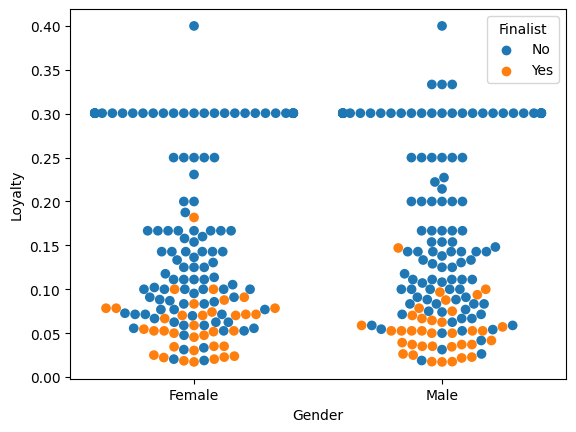

In [37]:
sns.swarmplot(data=data, x="Gender", y="Loyalty", hue="Finalist", size=7)

Loyalty Score seems to be a very useful data point in determining success.

### Location

([<matplotlib.patches.Wedge at 0x7f2acc1c1ab0>,
 [Text(-0.03873352613886081, 1.0993178402777108, 'South'),
  Text(-0.7967553715226898, -0.7584068024152609, 'Midlands'),
  Text(0.34286484458387395, -1.045200314938948, 'North'),
  Text(0.8579401985544105, -0.6884319978795429, 'Scotland'),
  Text(1.0032120447742328, -0.45118243895336047, 'Ireland'),
  Text(1.0786744125775438, -0.21554932533063292, 'Wales'),
  Text(1.0982539389255885, -0.0619538992673572, 'NFR'),
  Text(1.0998908428812697, -0.015496249414947698, 'Islands')])

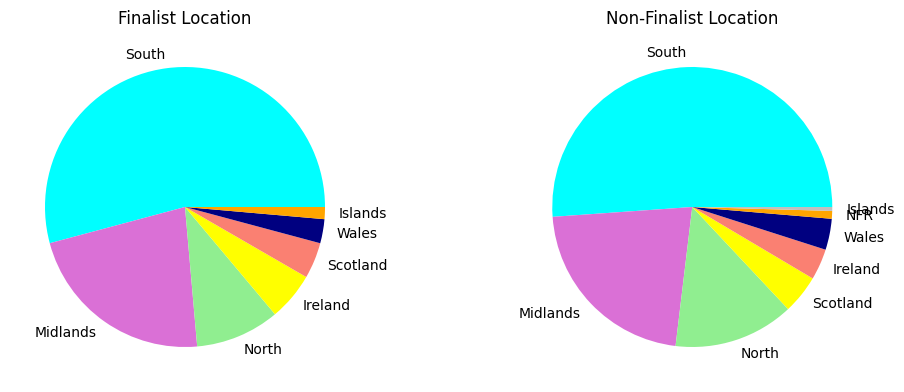

In [38]:
#Location of finalists vs non finalists
finalist_location = finalists['Final_Location2'].value_counts()
non_finalist_location = non_finalists['Final_Location2'].value_counts()

colors = ['cyan', 'orchid', 'lightgreen', 'yellow', 'salmon', 'navy', 'orange', 'silver']

fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(221)
ax1.set_title('Finalist Location')
ax1.pie(finalist_location, labels=finalist_location.index, colors = colors)

ax2 = fig.add_subplot(222)
ax2.set_title('Non-Finalist Location')
ax2.pie(non_finalist_location, labels=non_finalist_location.index, colors = colors)

This datapoint doesn't seem to be incredibly impactful at this time but building the infastructure to analyze this is important since a trend may appear as more data gets added to the model.

### Encoding
*********

Even  though I am not using location in modeling, I will encode it now in case I use it down the road when adding more data.

In [39]:
#Creating dummy columns for location

location_dummies = pd.get_dummies(data['Final_Location2'])
location_dummies.head()

,Ireland,Islands,Midlands,NFR,North,Scotland,South,Wales
0,False,False,True,False,False,False,False,False
1,False,False,False,False,True,False,False,False
2,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,True,False
4,False,False,False,False,False,True,False,False


In [40]:
#concat newly created columns with original dataframe
data = pd.concat([data, location_dummies],axis=1)

In [41]:
data.head()

,Name,Season,Gender,Age,Height,Ethnicity,Hair,Eye,Hometown,Region,...,Final_Location,Final_Location2,Ireland,Islands,Midlands,NFR,North,Scotland,South,Wales
0,Malia Arkian,2,Female,26,66,MENAT,Brown,Brown,Wilmslow,England,...,,Midlands,False,False,True,False,False,False,False,False
1,Ben Porter,1,Male,24,71,White,Brown,Blue,Wakefield,England,...,,North,False,False,False,False,True,False,False,False
2,Poppy Farnan,1,Female,22,66,White,Blonde,Blue,Cheshire,England,...,,South,False,False,False,False,False,False,True,False
3,Oliver Maxwell Fernandez,2,Male,25,74,White,Brown,Brown,Hertfordshire,England,...,,South,False,False,False,False,False,False,True,False
4,Shannon Singh,7,Female,22,68,Asian,Brown,Brown,Fife,Scotland,...,,Scotland,False,False,False,False,False,True,False,False


## Drop Columns that will not be used in Modeling

In [42]:
#Drop unnecessary columns and view resulting dataframe
column_drops = ['Ethnicity', 'Hair', 'Eye',	'Hometown',	'Region', 'Stay', 'Dumped', 'OG', 'Casa', 'Status', 'Couples', 'Location', 'Final_Location', 'Final_Location2', 'Ireland', 'Islands', 'Midlands', 'NFR', 'North', 'Scotland', 'South', 'Wales']
model_data = data.drop(columns=column_drops)
model_data.head()

,Name,Season,Gender,Age,Height,Entered,Finalist,Loyalty
0,Malia Arkian,2,Female,26,66,7,No,0.300598
1,Ben Porter,1,Male,24,71,32,No,0.300598
2,Poppy Farnan,1,Female,22,66,32,No,0.300598
3,Oliver Maxwell Fernandez,2,Male,25,74,30,No,0.300598
4,Shannon Singh,7,Female,22,68,1,No,0.300598


## Final Processing Touches

In [43]:
#Convert Gender and Finalist to binary values

model_data['Gender'] = model_data['Gender'].map({'Male': 1, 'Female': 0})
model_data['Finalist'] = model_data['Finalist'].map({'Yes': 1, 'No': 0})

In [44]:
#Check datatypes 
model_data.dtypes

Name         object
Season        int64
Gender        int64
Age           int64
Height        int64
Entered       int64
Finalist      int64
Loyalty     float64
dtype: object

In [45]:
#Set proper datatypes
#Name is string
#Season is categorical - '1' really is shorthand for 'Season 1'
#Age, Height, Entered are numerical
#Finalist to be bool
#Loyalty as float64
model_data['Name'] = model_data['Name'].astype('string') 
model_data['Season'] = model_data['Season'].astype('category')
model_data[['Gender', 'Finalist']] = model_data[['Gender','Finalist']].astype('bool')

In [46]:
#Check datatypes again
model_data.dtypes

Name        string[python]
Season            category
Gender                bool
Age                  int64
Height               int64
Entered              int64
Finalist              bool
Loyalty            float64
dtype: object

In [47]:
#Set Name as index so it is ignored by model
model_data = model_data.set_index('Name')

In [48]:
model_data.head()

,Season,Gender,Age,Height,Entered,Finalist,Loyalty
Name,,,,,,,
Malia Arkian,2,False,26,66,7,False,0.300598
Ben Porter,1,True,24,71,32,False,0.300598
Poppy Farnan,1,False,22,66,32,False,0.300598
Oliver Maxwell Fernandez,2,True,25,74,30,False,0.300598
Shannon Singh,7,False,22,68,1,False,0.300598


### Split Dataset

I will split this data by season.
- Train: Seasons 1-7: n-224 or ~76%
- Validate: Season 8: n-36 or ~12%
- Test: Season 9: n-35 or ~ 12% <br>

In [49]:
#Train, validate, test splits
def train_val_test(data, label):

    train_szn = [1, 2, 3, 4, 5, 6, 7]
    validate_szn = 8
    test_szn = 9


    train = data[data['Season'].isin(train_szn)]
    validate = data[data['Season'] == validate_szn]
    test = data[data['Season'] == test_szn]

    x_train = train.drop(columns=[label])
    y_train = train[label]

    x_validate = validate.drop(columns=[label])
    y_validate = validate[label]

    x_test = test.drop(columns=[label])
    y_test = test[label]

    print('Train Split: ', x_train.shape, '| Validate Split: ', x_validate.shape, '| Test Split: ', x_test.shape)

    return x_train, y_train, x_validate, y_validate, x_test, y_test

In [50]:
x_train, y_train, x_validate, y_validate, x_test, y_test = train_val_test(model_data, 'Finalist')

Train Split:  (224, 6) | Validate Split:  (36, 6) | Test Split:  (35, 6)


In [51]:
x_train.head()

,Season,Gender,Age,Height,Entered,Loyalty
Name,,,,,,
Malia Arkian,2,False,26,66,7,0.300598
Ben Porter,1,True,24,71,32,0.300598
Poppy Farnan,1,False,22,66,32,0.300598
Oliver Maxwell Fernandez,2,True,25,74,30,0.300598
Shannon Singh,7,False,22,68,1,0.300598


In [52]:
y_train.head()

Name
Malia Arkian                False
Ben Porter                  False
Poppy Farnan                False
Oliver Maxwell Fernandez    False
Shannon Singh               False
Name: Finalist, dtype: bool

I will put the train_val_test function into a python file and import it into my modeling notebook to split data there.

#### Convert Final Preprocessed dataframe to CSV

In [53]:
#Convert dataframe from this notebook to a csv to use for modeling.
model_data.to_csv(cwd + '/data/model_data.csv')